In [16]:
import pandas as pd

Наши новости

In [17]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [18]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [19]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [31]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [32]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [33]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [34]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [35]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 20.7 s


In [36]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 36s


А теперь в 3 строчки обучим нашу модель

In [37]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [53]:
common_dictionary[0]

'nn'

Все просто - это словарь наших слов

Запускаем обучение

In [54]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 25.4 s


In [57]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [58]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.15100035),
 (1, 0.024766888),
 (2, 0.027892446),
 (3, 0.048991963),
 (14, 0.18160123),
 (16, 0.021672979),
 (22, 0.5278155)]

In [60]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: смерть греция тур испания латвия германия комплексный
topic_1: товар рейтинг журнал подсчитать доход писать студия
topic_2: год украина страна россия правительство млрд решение
topic_3: фестиваль турецкий турция сон гость новгород лестница
topic_4: гражданин ребёнок фильм народный общество ск улица
topic_5: год который компания это экономика цена nn
topic_6: женщина тело данные место мужчина ребёнок вода
topic_7: рак млрд больной флот атмосферный гора сбить
topic_8: взрыв экипаж катастрофа час пилот произойти км
topic_9: это год ракета земля который мочь весь
topic_10: небо тепло миллиард областной разделение категорически неопределённость
topic_11: год который это россия российский сша также
topic_12: праздник грунт парка игра советовать зимний австралийский
topic_13: восток форум обращение ведение физика молдавия куба
topic_14: млн год стать составить банк стоимость сообщать
topic_15: военный напомнить армия год космонавт иран академия
topic_16: космос рекомендовать параметр

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [61]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [62]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.000000,0.000000,0.0,0.169362,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.016700,0.0,0.0,0.0,0.322146,0.0,0.484291
1,4896,0.214840,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.504024,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.259130
2,4897,0.150997,0.024767,0.027898,0.049003,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.021671,0.0,0.000000,0.0,0.0,0.0,0.527778,0.0,0.000000
3,4898,0.093428,0.000000,0.000000,0.011993,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.022642,0.0,0.0,0.0,0.312724,0.0,0.000000
4,4899,0.000000,0.000000,0.196093,0.000000,0.0,0.000000,0.0,0.0,0.065038,...,0.0,0.098765,0.0,0.122234,0.0,0.0,0.0,0.000000,0.0,0.407411


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [63]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [64]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [65]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05895264, 0.        ,
       0.        , 0.07354786, 0.01474219, 0.        , 0.06417838,
       0.        , 0.        , 0.        , 0.        , 0.08008198,
       0.14215828, 0.0908702 , 0.16548827, 0.21455202, 0.08631041])

In [66]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [67]:
get_user_embedding(user_articles_list)

array([0.        , 0.01022019, 0.04956942, 0.        , 0.00566535,
       0.02764351, 0.01921434, 0.00263975, 0.        , 0.04917382,
       0.        , 0.18025349, 0.        , 0.        , 0.        ,
       0.03969676, 0.        , 0.        , 0.0145293 , 0.        ,
       0.12112082, 0.1323653 , 0.13071547, 0.04785394, 0.15785193])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [69]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [71]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [72]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.004222,0.075662,0.033463,0.021538,0.042756,0.019857,0.000000,0.014830,...,0.002081,0.000000,0.002861,0.016762,0.013347,0.093627,0.028512,0.027581,0.111768,0.099100
1,u108690,0.0,0.000000,0.072996,0.000000,0.013323,0.043128,0.029824,0.005691,0.011782,...,0.019790,0.000000,0.000000,0.016647,0.000000,0.049659,0.080972,0.155927,0.107230,0.149936
2,u108339,0.0,0.001953,0.072357,0.003250,0.010701,0.035145,0.084641,0.000000,0.011152,...,0.012192,0.002832,0.000000,0.017078,0.006272,0.067827,0.045804,0.027778,0.130525,0.175413


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [73]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [74]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.004222,0.075662,0.033463,0.021538,0.042756,0.019857,0.000000,0.014830,...,0.000000,0.002861,0.016762,0.013347,0.093627,0.028512,0.027581,0.111768,0.099100,0
1,u108690,0.0,0.000000,0.072996,0.000000,0.013323,0.043128,0.029824,0.005691,0.011782,...,0.000000,0.000000,0.016647,0.000000,0.049659,0.080972,0.155927,0.107230,0.149936,1
2,u108339,0.0,0.001953,0.072357,0.003250,0.010701,0.035145,0.084641,0.000000,0.011152,...,0.002832,0.000000,0.017078,0.006272,0.067827,0.045804,0.027778,0.130525,0.175413,1


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [84]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [85]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [86]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.2324957 , 0.01763011, 0.62523448, 0.176945  , 0.07255784,
       0.06412364, 0.1228885 , 0.00994882, 0.07009161, 0.19155923])

In [87]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.293252, F-Score=0.693, Precision=0.681, Recall=0.706


In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1674   81]
 [  73  172]]


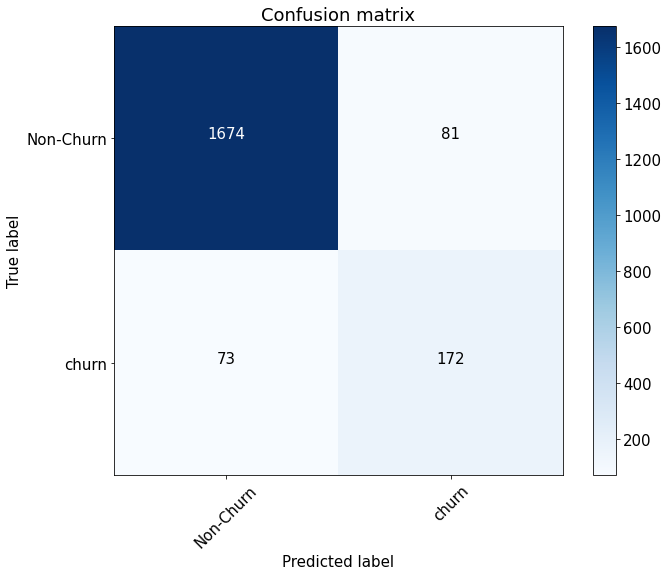

In [112]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [110]:
roc_auc_score(y_test, preds)

0.951487877202163

### Метрики при использовании mean

In [111]:
fscore_mean = fscore[ix]
precision_mean = precision[ix]
recall_mean = recall[ix]
roc_auc_score_mean = roc_auc_score(y_test, preds)
print(f'fscore_mean={fscore_mean}\nprecision_mean={precision_mean}\nrecall_mean={recall_mean}\nroc_auc_score_mean={roc_auc_score_mean}')

fscore_mean=0.6933867735470942
precision_mean=0.6811023622047244
recall_mean=0.7061224489795919
roc_auc_score_mean=0.951487877202163


# Медиана

In [129]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [130]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00566073, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15096031, 0.        , 0.        , 0.        ,
       0.01221449, 0.        , 0.        , 0.        , 0.        ,
       0.02393997, 0.05496636, 0.08771144, 0.03192764, 0.09548787])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [131]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [132]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [133]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.039358,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.073806,0.000000,0.000000,0.140375,0.043155
1,u108690,0.0,0.0,0.051671,0.0,0.0,0.057529,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018634,0.048189,0.111711,0.097778,0.109234
2,u108339,0.0,0.0,0.079231,0.0,0.0,0.024938,0.066619,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029602,0.038609,0.000000,0.124730,0.154256


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [134]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [135]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.039358,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.073806,0.000000,0.000000,0.140375,0.043155,0
1,u108690,0.0,0.0,0.051671,0.0,0.0,0.057529,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018634,0.048189,0.111711,0.097778,0.109234,1
2,u108339,0.0,0.0,0.079231,0.0,0.0,0.024938,0.066619,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029602,0.038609,0.000000,0.124730,0.154256,1


In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [138]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [139]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28053861, 0.02463065, 0.51981902, 0.38043143, 0.03725755,
       0.01815926, 0.0620359 , 0.02434998, 0.12936694, 0.23320479])

In [140]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [141]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.272338, F-Score=0.759, Precision=0.682, Recall=0.857


In [142]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1657   98]
 [  36  209]]


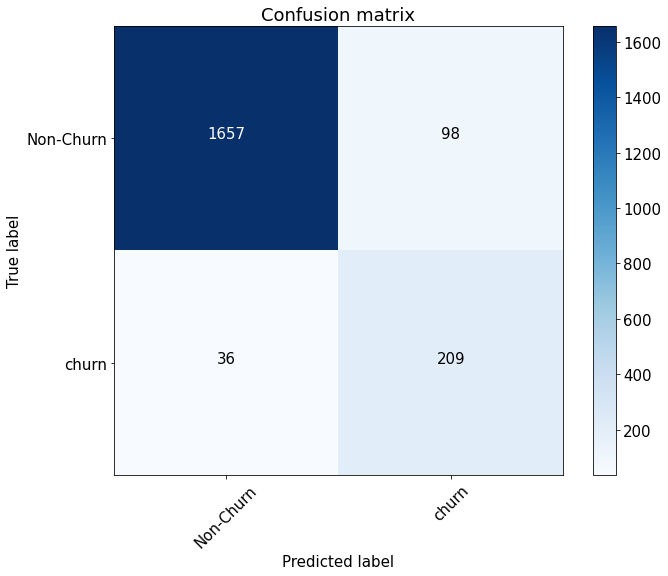

In [143]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [144]:
roc_auc_score(y_test, preds)

0.9691935577649862

### Метрики при использовании median

In [146]:
fscore_median = fscore[ix]
precision_median = precision[ix]
recall_median = recall[ix]
roc_auc_score_median = roc_auc_score(y_test, preds)
print(f'fscore_median={fscore_median}\nprecision_median={precision_median}\nrecall_median={recall_median}\nroc_auc_score_median={roc_auc_score_median}')

fscore_median=0.759493670886076
precision_median=0.6818181818181818
recall_median=0.8571428571428571
roc_auc_score_median=0.9691935577649862


# Max

In [147]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [148]:
get_user_embedding(user_articles_list)

array([0.        , 0.06132111, 0.26715809, 0.        , 0.03399213,
       0.09374323, 0.11528604, 0.0158385 , 0.        , 0.2950429 ,
       0.        , 0.40453762, 0.        , 0.        , 0.        ,
       0.16876365, 0.        , 0.        , 0.07463229, 0.        ,
       0.48175135, 0.41981232, 0.34613487, 0.16333005, 0.64262658])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [149]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [150]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [151]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.025331,0.196991,0.200781,0.119143,0.256536,0.089021,0.000000,0.058953,...,0.012487,0.000000,0.017168,0.059042,0.080082,0.271991,0.090870,0.165488,0.214552,0.290974
1,u108690,0.0,0.000000,0.187760,0.000000,0.043620,0.072956,0.123323,0.034146,0.070689,...,0.074598,0.000000,0.000000,0.084333,0.000000,0.184642,0.238415,0.407757,0.184875,0.403265
2,u108339,0.0,0.011720,0.161488,0.019499,0.040449,0.120319,0.252433,0.000000,0.047847,...,0.073154,0.016992,0.000000,0.072759,0.020885,0.309384,0.098488,0.124379,0.193811,0.301090


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [152]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [153]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.025331,0.196991,0.200781,0.119143,0.256536,0.089021,0.000000,0.058953,...,0.000000,0.017168,0.059042,0.080082,0.271991,0.090870,0.165488,0.214552,0.290974,0
1,u108690,0.0,0.000000,0.187760,0.000000,0.043620,0.072956,0.123323,0.034146,0.070689,...,0.000000,0.000000,0.084333,0.000000,0.184642,0.238415,0.407757,0.184875,0.403265,1
2,u108339,0.0,0.011720,0.161488,0.019499,0.040449,0.120319,0.252433,0.000000,0.047847,...,0.016992,0.000000,0.072759,0.020885,0.309384,0.098488,0.124379,0.193811,0.301090,1


In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [155]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [156]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [157]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.44575535, 0.00747375, 0.84398655, 0.11563064, 0.0097782 ,
       0.01312527, 0.10104541, 0.00328886, 0.12045134, 0.38238444])

In [158]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [159]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.374726, F-Score=0.794, Precision=0.801, Recall=0.788


In [160]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1707   48]
 [  53  192]]


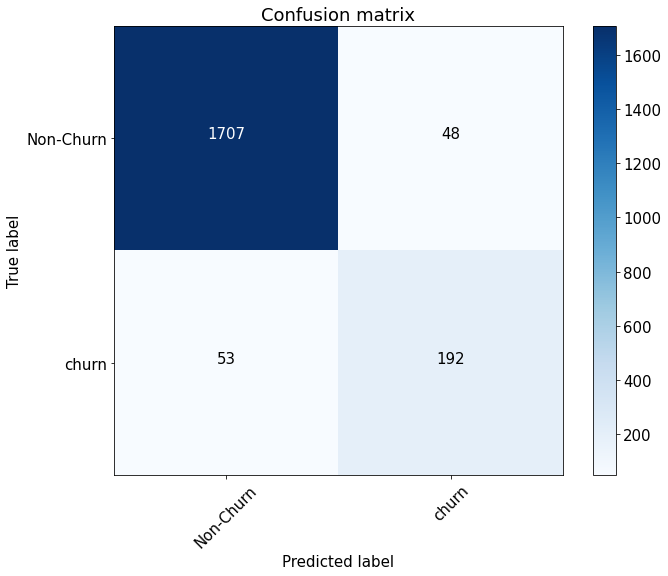

In [161]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [162]:
roc_auc_score(y_test, preds)

0.9764149078434793

### Метрики при использовании max

In [163]:
fscore_max = fscore[ix]
precision_max = precision[ix]
recall_max = recall[ix]
roc_auc_score_max = roc_auc_score(y_test, preds)
print(f'fscore_max={fscore_max}\nprecision_max={precision_max}\nrecall_max={recall_max}\nroc_auc_score_max={roc_auc_score_max}')

fscore_max=0.7942386831275722
precision_max=0.8008298755186722
recall_max=0.7877551020408163
roc_auc_score_max=0.9764149078434793


### Формируем итоговую таблицу

In [175]:
rows = ['mean', 'median', 'max']
total_dict = {'fscore': [fscore_mean, fscore_median, fscore_max],
              'precision': [precision_mean, precision_median, precision_max],
              'recall': [recall_mean, recall_median, recall_max],
              'roc_auc_score': [roc_auc_score_mean, roc_auc_score_median, roc_auc_score_max]
            } 
total_table = pd.DataFrame(total_dict, index=rows)
total_table

,fscore,precision,recall,roc_auc_score
mean,0.693387,0.681102,0.706122,0.951488
median,0.759494,0.681818,0.857143,0.969194
max,0.794239,0.800830,0.787755,0.976415


По савокупности коэффициэнтов метод max оказался самым лучшим.

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk